## Bird Modeling

In [11]:
import pandas as pd
import numpy as np
import os
import pickle

import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from xgboost import XGBClassifier

def split_train_test(X,y, test_ratio):
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio, random_state=1)
    for train_idx, test_idx in split.split(X, y):
        X_train = X.loc[train_idx]
        X_test = X.loc[test_idx]
        y_train = y.loc[train_idx]
        y_test = y.loc[test_idx]
    return X_train, X_test, y_train, y_test

### logistic regression

In [42]:
dict_model = {}

for name in list(dict_data.keys()):

    X = dict_data[name][['bio1', 'bio2', 'bio3', 'bio4', 'bio5', 'bio6', 'bio7',
           'bio8', 'bio9', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15',
           'bio16', 'bio17', 'bio18', 'bio19', 'pet', 'rh', 'srad', 'lon', 'lat',
           'alt']]
    y = dict_data[name]['y']

    X_train, X_test, y_train, y_test = split_train_test(X, y,0.3)


    # define model
    weights = {0:0.01, 1:1.0}
    model = LogisticRegression(solver='lbfgs', class_weight=weights, max_iter=10000)
    model.fit(X_train, y_train)
    print(f'########################### classification report for {name} ###########################')
    print(classification_report(y_test, model.predict(X_test)))
    print('\n')
    
    dict_model[name] = model

########################### classification report for 수리부엉이 ###########################
              precision    recall  f1-score   support

           0       1.00      0.81      0.89       930
           1       0.01      0.40      0.02         5

    accuracy                           0.81       935
   macro avg       0.50      0.61      0.46       935
weighted avg       0.99      0.81      0.89       935



########################### classification report for 팔색조 ###########################
              precision    recall  f1-score   support

           0       1.00      0.84      0.91       924
           1       0.06      0.82      0.11        11

    accuracy                           0.84       935
   macro avg       0.53      0.83      0.51       935
weighted avg       0.99      0.84      0.90       935



########################### classification report for 큰고니 ###########################
              precision    recall  f1-score   support

           0       1.00    

/Users/shinbo/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## random forest

In [2]:
def rf_gridSearch_train(X_train, y_train, save, file_dir=None):
    param_grid = {'bootstrap': [True, False],
     'max_depth': [ 80, 90, 100, None],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10],
     'n_estimators': [600, 800, 1000]
                 }

    # Create a based model
    rf = RandomForestClassifier()
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                              cv = 3, n_jobs = -1, verbose = 2)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # best params

    rf_best_est = grid_search.best_estimator_
    rf = rf_best_est.fit(X_train, y_train)

    rf.fit(X_train, y_train)
    
    if save:
        pickle.dump(rf, open(file_dir, 'wb'))
    
    return rf

def print_result(model, X_test, y_test):
    pred = model.predict(X_test)

    print(classification_report(y_test, pred))
    
    print('ROC/AUC: ', roc_auc_score(y_test, pred))
    print('ACC: ', accuracy_score(y_test, pred))
    print('PREC: ', precision_score(y_test, pred))
    print('RECALL: ', recall_score(y_test, pred))
    print('F1: ', f1_score(y_test, pred))

    print('Confusion Matrix: \n', confusion_matrix(y_test, pred))

### RF with 2% ~ 5% 
* with randomized grid search
* adjusting class_weight
* save models with roc_auc_score over 0.7

In [17]:
dir_name = '/Users/shinbo/Desktop/contest/environ/concat_data/bird/etc/2%~5%/'
dir_list = sorted(os.listdir(dir_name))[1:]
dict_model_rf = {}
save_dir = '/Users/shinbo/Desktop/contest/environ/model/bird/'


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


for _dir in dir_list:
    
    tmp = pd.read_csv(dir_name + _dir)
    X = tmp[['bio1', 'bio2', 'bio3', 'bio4', 'bio5', 'bio6', 'bio7',
           'bio8', 'bio9', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15',
           'bio16', 'bio17', 'bio18', 'bio19', 'pet', 'rh', 'srad']]
    y = tmp['y']
    
    weight = len(np.where(y == 0)[0]) / len(np.where(y == 1)[0])

    X_train, X_test, y_train, y_test = split_train_test(X, y,0.3)
    
    # Create a based model
    rf = RandomForestClassifier(class_weight={0:1,1:weight})
    # Instantiate the grid search model
    grid_search = RandomizedSearchCV(estimator = rf, param_distributions = params, 
                                     cv = 3, verbose=2, random_state=42, n_jobs = -1)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # best params

    rf_best_est = grid_search.best_estimator_
    rf = rf_best_est.fit(X_train, y_train)

    rf.fit(X_train, y_train)
   
    
    pred = rf.predict(X_test)
    roc_score = roc_auc_score(y_test,pred)
    if roc_score >= 0.7:        
        print('\n')
        print(f'########################### classification report for {_dir[:-4]} ###########################')
        print_result(rf,X_test,y_test)
        dict_model_rf[_dir[:-4]] = rf
        print('\n')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   18.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   15.6s finished




########################### classification report for 까치 ###########################
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       901
           1       0.62      0.85      0.72        34

    accuracy                           0.98       935
   macro avg       0.81      0.92      0.85       935
weighted avg       0.98      0.98      0.98       935

ROC/AUC:  0.9164816870144284
ACC:  0.9754010695187165
PREC:  0.6170212765957447
RECALL:  0.8529411764705882
F1:  0.7160493827160493
Confusion Matrix: 
 [[883  18]
 [  5  29]]


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   14.2s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.8s finished




########################### classification report for 동박새 ###########################
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       914
           1       0.63      0.57      0.60        21

    accuracy                           0.98       935
   macro avg       0.81      0.78      0.80       935
weighted avg       0.98      0.98      0.98       935

ROC/AUC:  0.781884964051266
ACC:  0.9828877005347594
PREC:  0.631578947368421
RECALL:  0.5714285714285714
F1:  0.6
Confusion Matrix: 
 [[907   7]
 [  9  12]]


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   17.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   16.0s finished




########################### classification report for 멧비둘기 ###########################
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       901
           1       0.67      0.82      0.74        34

    accuracy                           0.98       935
   macro avg       0.83      0.90      0.86       935
weighted avg       0.98      0.98      0.98       935

ROC/AUC:  0.9039955604883464
ACC:  0.9786096256684492
PREC:  0.6666666666666666
RECALL:  0.8235294117647058
F1:  0.7368421052631577
Confusion Matrix: 
 [[887  14]
 [  6  28]]


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   15.5s finished




########################### classification report for 박새 ###########################
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       900
           1       0.55      0.51      0.53        35

    accuracy                           0.97       935
   macro avg       0.76      0.75      0.76       935
weighted avg       0.96      0.97      0.97       935

ROC/AUC:  0.7488095238095238
ACC:  0.9657754010695188
PREC:  0.5454545454545454
RECALL:  0.5142857142857142
F1:  0.5294117647058822
Confusion Matrix: 
 [[885  15]
 [ 17  18]]


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   19.9s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   20.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   20.0s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   23.0s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   23.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.4s finished




########################### classification report for 섬휘파람새 ###########################
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       912
           1       0.73      0.96      0.83        23

    accuracy                           0.99       935
   macro avg       0.87      0.97      0.91       935
weighted avg       0.99      0.99      0.99       935

ROC/AUC:  0.9738749046529367
ACC:  0.9903743315508021
PREC:  0.7333333333333333
RECALL:  0.9565217391304348
F1:  0.8301886792452831
Confusion Matrix: 
 [[904   8]
 [  1  22]]


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   20.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   15.9s finished




########################### classification report for 직박구리 ###########################
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       888
           1       0.80      0.85      0.82        47

    accuracy                           0.98       935
   macro avg       0.90      0.92      0.91       935
weighted avg       0.98      0.98      0.98       935

ROC/AUC:  0.9199012842629863
ACC:  0.9818181818181818
PREC:  0.8
RECALL:  0.851063829787234
F1:  0.8247422680412372
Confusion Matrix: 
 [[878  10]
 [  7  40]]


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   15.1s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   20.2s finished




########################### classification report for 큰부리까마귀 ###########################
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       905
           1       0.55      0.53      0.54        30

    accuracy                           0.97       935
   macro avg       0.77      0.76      0.76       935
weighted avg       0.97      0.97      0.97       935

ROC/AUC:  0.7594843462246776
ACC:  0.9711229946524064
PREC:  0.5517241379310345
RECALL:  0.5333333333333333
F1:  0.5423728813559322
Confusion Matrix: 
 [[892  13]
 [ 14  16]]


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   24.1s finished


### random forest 5%~
* with randomized grid search
* adjusting class_weight
* save models with roc_auc_score over 0.7

In [21]:
dir_name = '/Users/shinbo/Desktop/contest/environ/concat_data/bird/etc/5%~/'
dir_list = sorted(os.listdir(dir_name))[1:]
save_dir = '/Users/shinbo/Desktop/contest/environ/model/bird/'


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


for _dir in dir_list:
    
    tmp = pd.read_csv(dir_name + _dir)
    X = tmp[['bio1', 'bio2', 'bio3', 'bio4', 'bio5', 'bio6', 'bio7',
           'bio8', 'bio9', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15',
           'bio16', 'bio17', 'bio18', 'bio19', 'pet', 'rh', 'srad']]
    y = tmp['y']
    
    weight = len(np.where(y == 0)[0]) / len(np.where(y == 1)[0])

    X_train, X_test, y_train, y_test = split_train_test(X, y,0.3)
    
    # Create a based model
    rf = RandomForestClassifier(class_weight={0:1,1:weight})
    # Instantiate the grid search model
    grid_search = RandomizedSearchCV(estimator = rf, param_distributions = params, 
                                     cv = 3, verbose=2, random_state=42, n_jobs = -1)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # best params

    rf_best_est = grid_search.best_estimator_
    rf = rf_best_est.fit(X_train, y_train)

    rf.fit(X_train, y_train)
   
    
    pred = rf.predict(X_test)
    roc_score = roc_auc_score(y_test,pred)
    if roc_score >= 0.7:        
        print('\n')
        print(f'########################### classification report for {_dir[:-4]} ###########################')
        print_result(rf,X_test,y_test)
        dict_model_rf[_dir[:-4]] = rf
        print('\n')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   24.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   32.1s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   23.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   27.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   39.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   25.0s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   26.2s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   29.1s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   29.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   27.4s finished


In [22]:
pickle.dump(dict_model_rf, open('../model_dict_weight_adj/bird_rf.pickle', 'wb'))

### XG boosting with 2%~5%
* with randomized grid search
* adjusting scale_pos_weigh
* save models with roc_auc_score over 0.7

In [24]:
# etc 2% ~ 5%
dir_list = sorted(os.listdir('/Users/shinbo/Desktop/contest/environ/concat_data/bird/etc/2%~5%'))[1:]
dict_model_xgb = {}
for _dir in dir_list:
    
    tmp = pd.read_csv('/Users/shinbo/Desktop/contest/environ/concat_data/bird/etc/2%~5%/' + _dir)
    X = tmp[['bio1', 'bio2', 'bio3', 'bio4', 'bio5', 'bio6', 'bio7',
           'bio8', 'bio9', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15',
           'bio16', 'bio17', 'bio18', 'bio19', 'pet', 'rh', 'srad']]
    y = tmp['y']
    
    weight = len(np.where(y == 0)[0]) / len(np.where(y == 1)[0])

    X_train, X_test, y_train, y_test = split_train_test(X, y,0.3)

        # Create XGB Classifier object
    xgb_clf = XGBClassifier(scale_pos_weight = weight)

    # Create parameter grid
    parameters = {"learning_rate": [0.1, 0.01, 0.001],
                   "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
                   "max_depth": [2, 4, 7, 10],
                   "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
                   "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
                   "reg_alpha": [0, 0.5, 1],
                   "reg_lambda": [1, 1.5, 2, 3, 4.5],
                   "min_child_weight": [1, 3, 5, 7],
                   "n_estimators": [100, 250, 500, 1000]}

    print(f'starting optimizing for {_dir[:-4]}')
    # Create RandomizedSearchCV Object
    xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "roc_auc",
                                 cv = 5, random_state = 40 , n_jobs = -1, verbose = 2)
    print('done tuning')

    # Fit the model
    model_xgboost = xgb_rscv.fit(X_train, y_train)
    
    xgb_best = model_xgboost.best_estimator_
    
    final_xgb = xgb_best.fit(X_train, y_train)
    
    pred = final_xgb.predict(X_test)
    roc_score = roc_auc_score(y_test,pred)
    if roc_score >= 0.7:        
        print('\n')
        print(f'########################### classification report for {_dir[:-4]} ###########################')
        print_result(final_xgb,X_test,y_test)
        dict_model_xgb[_dir[:-4]] = final_xgb
        print('\n')

starting optimizing for 검은딱새
done tuning
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.1s finished


starting optimizing for 까치
done tuning
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.2s finished




########################### classification report for 까치 ###########################
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       901
           1       0.60      0.82      0.69        34

    accuracy                           0.97       935
   macro avg       0.79      0.90      0.84       935
weighted avg       0.98      0.97      0.98       935

ROC/AUC:  0.9012208657047724
ACC:  0.9732620320855615
PREC:  0.5957446808510638
RECALL:  0.8235294117647058
F1:  0.691358024691358
Confusion Matrix: 
 [[882  19]
 [  6  28]]


starting optimizing for 꿩
done tuning
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.8s finished




########################### classification report for 꿩 ###########################
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       910
           1       0.37      0.80      0.51        25

    accuracy                           0.96       935
   macro avg       0.68      0.88      0.74       935
weighted avg       0.98      0.96      0.97       935

ROC/AUC:  0.8813186813186813
ACC:  0.9582887700534759
PREC:  0.37037037037037035
RECALL:  0.8
F1:  0.5063291139240506
Confusion Matrix: 
 [[876  34]
 [  5  20]]


starting optimizing for 동박새
done tuning
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.8s finished




########################### classification report for 동박새 ###########################
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       914
           1       0.64      0.67      0.65        21

    accuracy                           0.98       935
   macro avg       0.81      0.83      0.82       935
weighted avg       0.98      0.98      0.98       935

ROC/AUC:  0.8289569657184537
ACC:  0.983957219251337
PREC:  0.6363636363636364
RECALL:  0.6666666666666666
F1:  0.6511627906976744
Confusion Matrix: 
 [[906   8]
 [  7  14]]


starting optimizing for 두견이
done tuning
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.0s finished




########################### classification report for 두견이 ###########################
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       906
           1       0.18      0.52      0.27        29

    accuracy                           0.91       935
   macro avg       0.58      0.72      0.61       935
weighted avg       0.96      0.91      0.93       935

ROC/AUC:  0.7205412194564969
ACC:  0.9112299465240642
PREC:  0.17857142857142858
RECALL:  0.5172413793103449
F1:  0.26548672566371684
Confusion Matrix: 
 [[837  69]
 [ 14  15]]


starting optimizing for 멧비둘기
done tuning
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.2s finished




########################### classification report for 멧비둘기 ###########################
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       901
           1       0.60      0.97      0.74        34

    accuracy                           0.98       935
   macro avg       0.80      0.97      0.86       935
weighted avg       0.98      0.98      0.98       935

ROC/AUC:  0.9730854605993342
ACC:  0.9754010695187165
PREC:  0.6
RECALL:  0.9705882352941176
F1:  0.7415730337078651
Confusion Matrix: 
 [[879  22]
 [  1  33]]


starting optimizing for 박새
done tuning
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.0s finished




########################### classification report for 박새 ###########################
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       900
           1       0.60      0.69      0.64        35

    accuracy                           0.97       935
   macro avg       0.79      0.83      0.81       935
weighted avg       0.97      0.97      0.97       935

ROC/AUC:  0.8339682539682539
ACC:  0.9711229946524064
PREC:  0.6
RECALL:  0.6857142857142857
F1:  0.64
Confusion Matrix: 
 [[884  16]
 [ 11  24]]


starting optimizing for 벙어리뻐꾸기
done tuning
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.8s finished


starting optimizing for 붉은배새매
done tuning
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.7s finished


starting optimizing for 뿔논병아리
done tuning
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.0s finished


starting optimizing for 새매
done tuning
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.2s finished


starting optimizing for 새호리기
done tuning
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.3s finished


starting optimizing for 섬휘파람새
done tuning
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.7s finished




########################### classification report for 섬휘파람새 ###########################
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       912
           1       0.71      0.96      0.81        23

    accuracy                           0.99       935
   macro avg       0.85      0.97      0.90       935
weighted avg       0.99      0.99      0.99       935

ROC/AUC:  0.9733266590389017
ACC:  0.9893048128342246
PREC:  0.7096774193548387
RECALL:  0.9565217391304348
F1:  0.8148148148148149
Confusion Matrix: 
 [[903   9]
 [  1  22]]


starting optimizing for 소쩍새
done tuning
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.2s finished


starting optimizing for 직박구리
done tuning
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.9s finished




########################### classification report for 직박구리 ###########################
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       888
           1       0.82      0.89      0.86        47

    accuracy                           0.99       935
   macro avg       0.91      0.94      0.92       935
weighted avg       0.99      0.99      0.99       935

ROC/AUC:  0.9417409430707303
ACC:  0.9850267379679144
PREC:  0.8235294117647058
RECALL:  0.8936170212765957
F1:  0.8571428571428571
Confusion Matrix: 
 [[879   9]
 [  5  42]]


starting optimizing for 참새
done tuning
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.0s finished




########################### classification report for 참새 ###########################
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       912
           1       0.54      0.65      0.59        23

    accuracy                           0.98       935
   macro avg       0.76      0.82      0.79       935
weighted avg       0.98      0.98      0.98       935

ROC/AUC:  0.818959763539283
ACC:  0.9775401069518717
PREC:  0.5357142857142857
RECALL:  0.6521739130434783
F1:  0.5882352941176471
Confusion Matrix: 
 [[899  13]
 [  8  15]]


starting optimizing for 큰부리까마귀
done tuning
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.0s finished




########################### classification report for 큰부리까마귀 ###########################
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       905
           1       0.51      0.77      0.61        30

    accuracy                           0.97       935
   macro avg       0.75      0.87      0.80       935
weighted avg       0.98      0.97      0.97       935

ROC/AUC:  0.8711786372007366
ACC:  0.9689839572192513
PREC:  0.5111111111111111
RECALL:  0.7666666666666667
F1:  0.6133333333333334
Confusion Matrix: 
 [[883  22]
 [  7  23]]


starting optimizing for 큰오색딱다구리
done tuning
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.3s finished


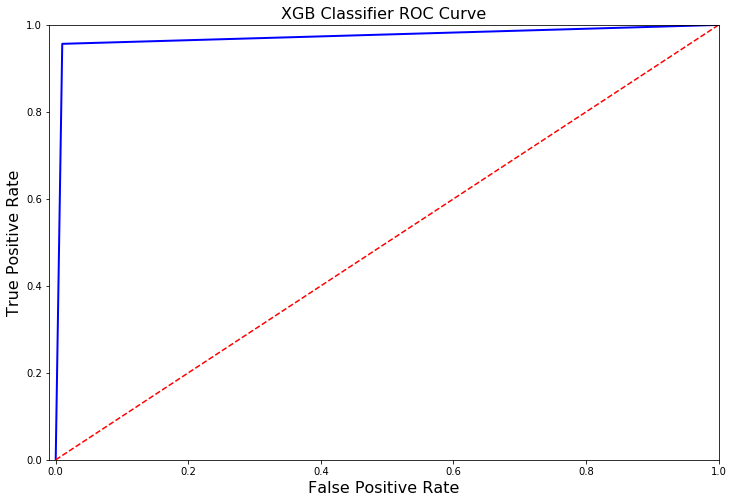

In [160]:
xgb_pred = dict_model_xgb['섬휘파람새'].predict(X_test)
log_fpr, log_tpr, log_thresold = roc_curve(y_test, xgb_pred)

def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('XGB Classifier ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
    
logistic_roc_curve(log_fpr, log_tpr)
plt.show()

### xgb over 5%~
* with randomized grid search
* adjusting scale_pos_weigh
* save models with roc_auc_score over 0.7

In [25]:
# etc 2% ~ 5%
dir_list = sorted(os.listdir('/Users/shinbo/Desktop/contest/environ/concat_data/bird/etc/5%~'))[1:]
from sklearn.model_selection import RandomizedSearchCV
for _dir in dir_list:
    
    tmp = pd.read_csv('/Users/shinbo/Desktop/contest/environ/concat_data/bird/etc/5%~/' + _dir)
    X = tmp[['bio1', 'bio2', 'bio3', 'bio4', 'bio5', 'bio6', 'bio7',
           'bio8', 'bio9', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15',
           'bio16', 'bio17', 'bio18', 'bio19', 'pet', 'rh', 'srad']]
    y = tmp['y']
    
    weight = len(np.where(y == 0)[0]) / len(np.where(y == 1)[0])

    X_train, X_test, y_train, y_test = split_train_test(X, y,0.3)

        # Create XGB Classifier object
    xgb_clf = XGBClassifier(scale_pos_weight = weight)

    # Create parameter grid
    parameters = {"learning_rate": [0.1, 0.01, 0.001],
                   "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
                   "max_depth": [2, 4, 7, 10],
                   "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
                   "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
                   "reg_alpha": [0, 0.5, 1],
                   "reg_lambda": [1, 1.5, 2, 3, 4.5],
                   "min_child_weight": [1, 3, 5, 7],
                   "n_estimators": [100, 250, 500, 1000]}

    print(f'starting optimizing for {_dir[:-4]}')
    # Create RandomizedSearchCV Object
    xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "roc_auc",
                                 cv = 5, random_state = 40 , n_jobs = -1, verbose = 2)
    print('done tuning')

    # Fit the model
    model_xgboost = xgb_rscv.fit(X_train, y_train)
    
    xgb_best = model_xgboost.best_estimator_
    
    final_xgb = xgb_best.fit(X_train, y_train)
    
    pred = final_xgb.predict(X_test)
    roc_score = roc_auc_score(y_test,pred)
    if roc_score >= 0.7:        
        print('\n')
        print(f'########################### classification report for {_dir[:-4]} ###########################')
        print_result(final_xgb,X_test,y_test)
        dict_model_xgb[_dir[:-4]] = final_xgb
        print('\n')

starting optimizing for 검은등뻐꾸기
done tuning
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.4s finished


starting optimizing for 꾀꼬리
done tuning
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.5s finished


starting optimizing for 되지빠귀
done tuning
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.3s finished


starting optimizing for 물총새
done tuning
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.9s finished


starting optimizing for 뻐꾸기
done tuning
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.1s finished


starting optimizing for 오색딱다구리
done tuning
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.9s finished


starting optimizing for 원앙
done tuning
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.0s finished


starting optimizing for 청딱다구리
done tuning
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.2s finished


starting optimizing for 파랑새
done tuning
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.2s finished


starting optimizing for 황조롱이
done tuning
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.0s finished


### xgb with 멸종위기

In [26]:
dir_list = [
    '/Users/shinbo/Desktop/contest/environ/concat_data/bird/second/2%~5%/참매.csv',
    '/Users/shinbo/Desktop/contest/environ/concat_data/bird/second/2%~5%/흰목물떼새.csv',
    '/Users/shinbo/Desktop/contest/environ/concat_data/bird/second/5%~/말똥가리.csv'
]
name = ['참매','흰목물떼새','말똥가리']

In [27]:
# etc 2% ~ 5%
for n,_dir in zip(name, dir_list):
    
    tmp = pd.read_csv(_dir)
    X = tmp[['bio1', 'bio2', 'bio3', 'bio4', 'bio5', 'bio6', 'bio7',
           'bio8', 'bio9', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15',
           'bio16', 'bio17', 'bio18', 'bio19', 'pet', 'rh', 'srad']]
    y = tmp['y']
    
    weight = len(np.where(y == 0)[0]) / len(np.where(y == 1)[0])

    X_train, X_test, y_train, y_test = split_train_test(X, y,0.3)

        # Create XGB Classifier object
    xgb_clf = XGBClassifier(scale_pos_weight = weight)

    # Create parameter grid
    parameters = {"learning_rate": [0.1, 0.01, 0.001],
                   "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
                   "max_depth": [2, 4, 7, 10],
                   "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
                   "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
                   "reg_alpha": [0, 0.5, 1],
                   "reg_lambda": [1, 1.5, 2, 3, 4.5],
                   "min_child_weight": [1, 3, 5, 7],
                   "n_estimators": [100, 250, 500, 1000]}

    print(f'starting optimizing for {_dir[:-4]}')
    # Create RandomizedSearchCV Object
    xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "roc_auc",
                                 cv = 5, random_state = 40 , n_jobs = -1, verbose = 2)
    print('done tuning')

    # Fit the model
    model_xgboost = xgb_rscv.fit(X_train, y_train)
    
    xgb_best = model_xgboost.best_estimator_
    
    final_xgb = xgb_best.fit(X_train, y_train)
    
    pred = final_xgb.predict(X_test)
    roc_score = roc_auc_score(y_test,pred)
    if roc_score >= 0.7:        
        print('\n')
        print(f'########################### classification report for {n} ###########################')
        print_result(final_xgb,X_test,y_test)
        dict_model_xgb[n] = final_xgb
        print('\n')

starting optimizing for /Users/shinbo/Desktop/contest/environ/concat_data/bird/second/2%~5%/참매
done tuning
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.2s finished


starting optimizing for /Users/shinbo/Desktop/contest/environ/concat_data/bird/second/2%~5%/흰목물떼새
done tuning
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.9s finished


starting optimizing for /Users/shinbo/Desktop/contest/environ/concat_data/bird/second/5%~/말똥가리
done tuning
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.2s finished


In [28]:
pickle.dump(dict_model_xgb, open('../model_dict_weight_adj/bird_xgb_exclude.pickle','wb'))

### data saving

In [29]:
# etc 2% ~ 5%
dir_list = sorted(os.listdir('/Users/shinbo/Desktop/contest/environ/concat_data/bird/etc/2%~5%'))[1:]
bird_data_dict = {}
for _dir in dir_list:
    
    if _dir[:-4] in list(dict_model_xgb.keys()):
        tmp = pd.read_csv('/Users/shinbo/Desktop/contest/environ/concat_data/bird/etc/2%~5%/' + _dir)
        X = tmp[['bio1', 'bio2', 'bio3', 'bio4', 'bio5', 'bio6', 'bio7',
               'bio8', 'bio9', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15',
               'bio16', 'bio17', 'bio18', 'bio19', 'pet', 'rh', 'srad']]
        y = tmp['y']

        X_train, X_test, y_train, y_test = split_train_test(X, y,0.3)
        bird_data_dict[_dir[:-4]] = {'X_train':X_train, 'X_test':X_test, 'y_train':y_train, 'y_test':y_test}

In [30]:
pickle.dump(bird_data_dict, open('../model_dict_weight_adj/bird_data.pickle','wb'))

## with SMOTE: Not Done

In [56]:
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit, cross_val_predict, RandomizedSearchCV

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold

### SMOTE RF with 2% ~ 5%

In [126]:
# etc 2% ~ 5%
dir_list = sorted(os.listdir('/Users/shinbo/Desktop/contest/environ/concat_data/bird/etc/2%~5%'))[1:]
dir_list = ['직박구리.csv','까치.csv','꿩.csv']
dict_model_rf_smote = {}
for _dir in dir_list:
    tmp = pd.read_csv('/Users/shinbo/Desktop/contest/environ/concat_data/bird/etc/2%~5%/' + _dir)
    X = tmp[['bio1', 'bio2', 'bio3', 'bio4', 'bio5', 'bio6', 'bio7',
           'bio8', 'bio9', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15',
           'bio16', 'bio17', 'bio18', 'bio19', 'pet', 'rh', 'srad', 'lon', 'lat',
           'alt']]
    y = tmp['y']


    sss = StratifiedKFold(n_splits=3, random_state=None, shuffle=False)

    for train_index, test_index in sss.split(X, y):
        print("Train:", train_index, "Test:", test_index)
        original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
        original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

    # Turn into an array
    original_Xtrain = original_Xtrain.values
    original_Xtest = original_Xtest.values
    original_ytrain = original_ytrain.values
    original_ytest = original_ytest.values

    # See if both the train and test label distribution are similarly distributed
    train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
    test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
    # print('-' * 100)

    print('Label Distributions: \n')
    print(train_counts_label/ len(original_ytrain))
    print(test_counts_label/ len(original_ytest))


    accuracy_lst = []
    precision_lst = []
    recall_lst = []
    f1_lst = []
    auc_lst = []

    param_grid = {'bootstrap': [True, False],
         'max_depth': [ 80, 90, 100, None],
         'max_features': ['auto', 'sqrt'],
         'min_samples_leaf': [1, 2, 4],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [600, 800, 1000]
                     }

    # Create a based model
    rf = RandomForestClassifier()
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                              cv = 3, n_jobs = -1, verbose = 2)

    for train, test in sss.split(original_Xtrain, original_ytrain):
        pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), grid_search) # SMOTE happens during Cross Validation not before..
        model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
        best_est = grid_search.best_estimator_
        prediction = best_est.predict(original_Xtrain[test])

        accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
        precision_lst.append(precision_score(original_ytrain[test], prediction))
        recall_lst.append(recall_score(original_ytrain[test], prediction))
        f1_lst.append(f1_score(original_ytrain[test], prediction))
        auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
        
    dict_model_rf_smote[_dir[:-4]] = best_est

    print('*'*20 + 'validation result' + '*'*20)
    print("accuracy: {}".format(np.mean(accuracy_lst)))
    print("precision: {}".format(np.mean(precision_lst)))
    print("recall: {}".format(np.mean(recall_lst)))
    print("f1: {}".format(np.mean(f1_lst)))

    print('*'*20 + 'test result' + '*'*20)
    print_result(best_est, original_Xtest, original_ytest)

Train: [  72   73   76 ... 3113 3114 3115] Test: [   0    1    2 ... 1068 1069 1070]
Train: [   0    1    2 ... 3113 3114 3115] Test: [  72   73   76 ... 2115 2116 2117]
Train: [   0    1    2 ... 2115 2116 2117] Test: [1971 1990 1991 ... 3113 3114 3115]
Label Distributions: 

[0.94995188 0.05004812]
[0.95086705 0.04913295]
Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 353 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 636 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1001 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed: 11.2min finished


Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 353 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 636 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1001 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed: 13.4min finished


Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 353 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 636 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1001 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed: 10.8min finished


********************validation result********************
accuracy: 0.9384090005477289
precision: 0.6161438326931284
recall: 0.6478991596638655
f1: 0.4100073777018094
********************test result********************
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       987
           1       0.00      0.00      0.00        51

    accuracy                           0.95      1038
   macro avg       0.48      0.50      0.49      1038
weighted avg       0.90      0.95      0.93      1038

ROC/AUC:  0.5
ACC:  0.9508670520231214
PREC:  0.0
RECALL:  0.0
F1:  0.0
Confusion Matrix: 
 [[987   0]
 [ 51   0]]
Train: [  85   86   88 ... 3113 3114 3115] Test: [   0    1    2 ... 1058 1059 1060]
Train: [   0    1    2 ... 3113 3114 3115] Test: [  85   86   88 ... 2099 2100 2105]
Train: [   0    1    2 ... 2099 2100 2105] Test: [1993 1996 1999 ... 3113 3114 3115]
Label Distributions: 

[0.96342637 0.03657363]
[0.96435453 0.03564547]
Fitting 3 fol

/Users/shinbo/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shinbo/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 353 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 636 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1001 tasks   

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 353 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 636 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1001 tasks      | elapsed: 10.1min


KeyboardInterrupt: 